In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

In [2]:

data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'train': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [3]:
train_dir = '/kaggle/input/datasetflores-marco-laime-gonzales/Dataset Flores/train'

test_dir = '/kaggle/input/datasetflores-marco-laime-gonzales/Dataset Flores/test'

valid_dir = '/kaggle/input/datasetflores-marco-laime-gonzales/Dataset Flores/valid'  


# Cargar datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
}

# Cargar DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False)
}

# Número de clases
num_classes = len(image_datasets['train'].classes)
#num_classes = len(image_datasets['test'].classes)

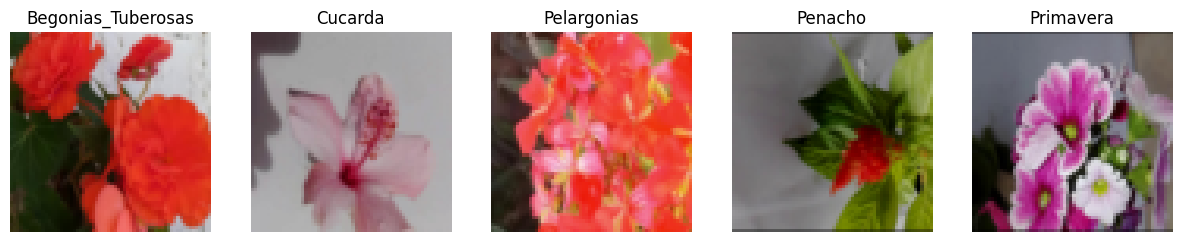

In [4]:
# Visualización de imágenes
import matplotlib.pyplot as plt
import random
classes = image_datasets['test'].classes
plt.figure(figsize=(15, 3))

# Obtener una imagen aleatoria por clase
for i, class_name in enumerate(classes):
    # Filtrar las imágenes que pertenecen a la clase actual
    class_indices = [idx for idx, (_, label) in enumerate(image_datasets['test'].imgs) if label == i]

    # Seleccionar un índice aleatorio de esta clase
    random_index = random.choice(class_indices)

    # Cargar la imagen correspondiente
    img, label = image_datasets['test'][random_index]

    # Convertir la imagen a un formato visible
    img = img.permute(1, 2, 0).numpy()  # Cambiar el orden de los ejes
    img = img * 0.5 + 0.5  # Desnormalizar la imagen

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
# Definir el tamaño de las imágenes, número de clases y otras variables según tu dataset
input_size = 64 * 64 * 3  # Tamaño de entrada para imágenes 64x64 con 3 canales
hidden_size = 100  # Número de neuronas en la capa oculta
output_size = len(image_datasets['train'].classes)  # Número de clases basado en tu dataset
dropout_prob = 0.5  # Probabilidad de Dropout

# MLP usando PyTorch con Dropout
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, input_size)  # Aplanar la imagen 64x64x3 a un vector de 12288
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Aplicar Dropout después de la activación
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Usamos log_softmax para la clasificación multiclase

# Instanciar el modelo
#model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dropout_prob=dropout_prob)

# Función de pérdida y optimizador
#criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score
from torch.nn.functional import softmax

def fit2(model, dataloaders, epochs=10, log_each=3, weight_decay=0, lr=0.001,early_stopping=0, device='cpu'):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.to(device)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_acc, step = 0, 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(dataloaders['train'])
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validación usando 'valid' en lugar de 'val'
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(dataloaders['valid'])
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

           # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1

        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break

        if epoch % log_each == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} loss {train_loss:.5f} acc {train_acc:.5f} val_loss {val_loss:.5f} val_acc {val_acc:.5f}")

    model.load_state_dict(torch.load('ckpt.pt'))
   
    return {
        'epoch': list(range(1, epochs + 1)),
        'loss': train_losses,
        'acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }


In [7]:
def fit(model, dataloaders, epochs=10, log_each=3, weight_decay=0, lr=0.001, early_stopping=0, device='cpu'):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.to(device)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_acc, step = 0, 0

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(dataloaders['train'])
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validación
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(dataloaders['valid'])
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Guardar el mejor modelo
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model_ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {epoch}")
        step += 1

        # Guardar un checkpoint cada 20 épocas
        if epoch % 20 == 0:
            torch.save(model.state_dict(), f'checkpoint_epoch_{epoch}.pt')
            print(f"Checkpoint guardado en epoch {epoch}.")

        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {epoch} por no mejorar en {early_stopping} epochs seguidas")
            break

        if epoch % log_each == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} loss {train_loss:.5f} acc {train_acc:.5f} val_loss {val_loss:.5f} val_acc {val_acc:.5f}")

    model.load_state_dict(torch.load('best_model_ckpt.pt'))

    return {
        'epoch': list(range(1, epochs + 1)),
        'loss': train_losses,
        'acc': train_accuracies,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }


In [8]:
# Instanciar modelo
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dropout_prob=0.5)

# Entrenar con regularización weight_decay y logs cada 10 epochs
#hist = fit(model, dataloaders, epochs=10, log_each=5, weight_decay=1e-4, lr=0.001, device='cuda')
hist = fit(model, dataloaders, epochs=100, log_each=1, weight_decay=0.001, lr=0.0001,early_stopping=20, device='cuda')



Mejor modelo guardado con acc 0.77337 en epoch 1
Epoch 1/100 loss 0.87168 acc 0.66140 val_loss 0.63454 val_acc 0.77337
Mejor modelo guardado con acc 0.80183 en epoch 2
Epoch 2/100 loss 0.69367 acc 0.74124 val_loss 0.55734 val_acc 0.80183
Mejor modelo guardado con acc 0.81453 en epoch 3
Epoch 3/100 loss 0.62724 acc 0.76943 val_loss 0.52250 val_acc 0.81453
Mejor modelo guardado con acc 0.82901 en epoch 4
Epoch 4/100 loss 0.59166 acc 0.78445 val_loss 0.48418 val_acc 0.82901
Epoch 5/100 loss 0.55857 acc 0.79825 val_loss 0.48392 val_acc 0.82279
Mejor modelo guardado con acc 0.84184 en epoch 6
Epoch 6/100 loss 0.53642 acc 0.80709 val_loss 0.44677 val_acc 0.84184
Mejor modelo guardado con acc 0.84210 en epoch 7
Epoch 7/100 loss 0.51953 acc 0.81052 val_loss 0.44310 val_acc 0.84210
Mejor modelo guardado con acc 0.85124 en epoch 8
Epoch 8/100 loss 0.50611 acc 0.81841 val_loss 0.43693 val_acc 0.85124
Epoch 9/100 loss 0.48783 acc 0.82211 val_loss 0.42702 val_acc 0.85074
Mejor modelo guardado con a

<ipython-input-7-acf77206d46e>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_ckpt.pt'))


----------------------Comentario------------------------

Epoch 10/200 loss 1.70899 acc 0.38276 val_loss 1.92265 val_acc 0.31150
Epoch 20/200 loss 1.49512 acc 0.46059 val_loss 2.39282 val_acc 0.29590

def fit(model, dataloader, epochs=200, log_each=10, weight_decay=0):

ValueError: All arrays must be of the same length

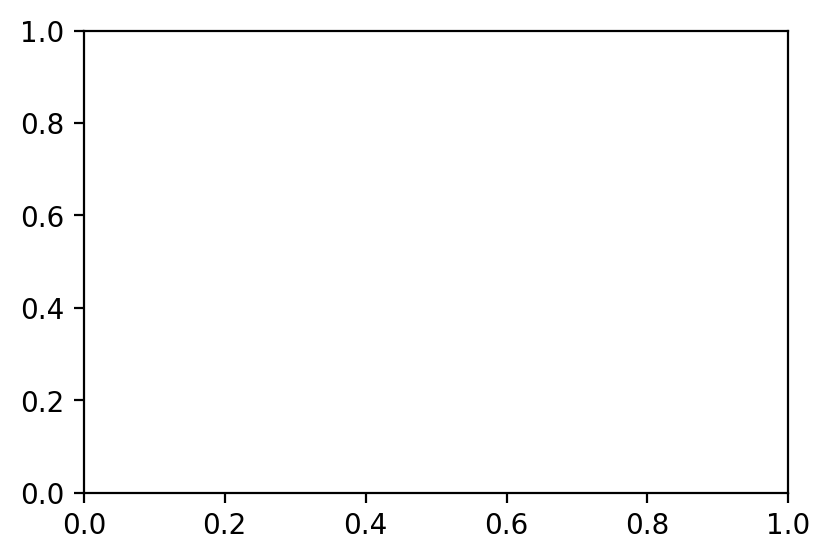

In [9]:
import pandas as pd
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [ ]:
# Función para exportar el modelo a TorchScript u ONNX con pre/post procesamiento
def export_model(model, device):
    class Preprocessing(torch.nn.Module):
        def __init__(self):
            super().__init__()

        def forward(self, x):
            x = x / 255.0  # Normalizar a [0, 1]
            x = (x - 0.1307) / 0.3081  # Normalización usando media y desviación estándar
            x = x.unsqueeze(1)  # Añadir dimensión de canal
            return x

    class Postprocessing(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.softmax = torch.nn.Softmax(dim=1)

        def forward(self, x):
            return self.softmax(x), torch.argmax(x, dim=1)

    # Modelo final: Preprocesamiento + Modelo + Postprocesamiento
    final_model = torch.nn.Sequential(
        Preprocessing(),   # Aplica el preprocesamiento
        model.cpu(),       # El modelo previamente entrenado
        Postprocessing()   # Aplica el postprocesamiento
    )

    # Convertir el modelo final a TorchScript
    scripted_model = torch.jit.script(final_model)
    scripted_model.save('model.zip')  # Guardar el modelo en un archivo .zip

    # Crear una entrada de ejemplo para el modelo ONNX (por ejemplo, imágenes de 224x224x3)
    dummy_input = torch.randn(1, 3, 224, 224).to(device)

    # Exportar el modelo final a ONNX
    torch.onnx.export(final_model, dummy_input, 'model.onnx', input_names=['input'], output_names=['output'], opset_version=12)

# Llamar a export_model después de haber entrenado el modelo
# export_model(model, device)

In [ ]:
# Instanciar el modelo
model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dropout_prob=dropout_prob)

# Función de pérdida y optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Función para guardar checkpoints
def save_checkpoint(model, optimizer, epoch, file_name="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, file_name)

In [ ]:
# Entrenamiento del modelo con checkpoints
def train_model(model, criterion, optimizer, dataloaders, epochs=100, checkpoint_interval=20):
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()  # Poner el modelo en modo de entrenamiento
        
        # Iterar sobre el dataloader de entrenamiento
        for inputs, labels in dataloaders['train']:
            optimizer.zero_grad()  # Limpiar los gradientes
            
            # Adelante (forward pass)
            outputs = model(inputs)
            
            # Calcular la pérdida
            loss = criterion(outputs, labels)
            
            # Hacia atrás (backward pass)
            loss.backward()
            
            # Actualizar los parámetros
            optimizer.step()
            
            running_loss += loss.item()

        # Guardar checkpoint cada "checkpoint_interval" epochs
        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(model, optimizer, epoch + 1, file_name=f"checkpoint_epoch_{epoch+1}.pth")
            print(f"Checkpoint saved at epoch {epoch+1}")

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloaders['train']):.4f}")
        


In [ ]:
train_model(model, criterion, optimizer, dataloaders, epochs=30)
# Evaluar el modelo en el conjunto de validación
#evaluate_model(model, dataloaders['valid'])

In [ ]:
# Validar el modelo
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #accuracy = 100 * correct / total
    print(f"Precisión del modelo: {100 * correct / total:.2f}%")



In [ ]:
evaluate_model(model, dataloaders['valid'])

------------Precisión del modelo: 99.96% ---> lr=0.001

------------Precisión del modelo: 21.61%% ----> 0.0005

  ----------20.44%------0.00005
  
  ----------17.19%------0.05

  -----------24.10% ------0.001

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Asumiendo que 'model' es tu modelo entrenado y 'dataloaders' es tu DataLoader

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Asumiendo que tu modelo tiene una capa llamada 'fc1' como la primera capa totalmente conectada
            output = model.fc1(inputs.view(inputs.size(0), -1))
            features.append(output)
            labels.append(targets)
    features = torch.cat(features).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    return features, labels

# Extraer características
features, labels = extract_features(model, dataloaders['test'])

# Reducir dimensionalidad
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Visualización
def plot_reduced_features(reduced_features, labels, class_names):
    plt.figure(figsize=(10, 8))
    markers = ['s', 'x', 'o', '^', 'v']
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    for i, class_name in enumerate(class_names):
        plt.scatter(reduced_features[labels == i, 0], reduced_features[labels == i, 1], 
                    alpha=0.7, marker=markers[i], c=colors[i], label=class_name)
    plt.title('Plant Dataset - Reduced Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Nombres de las clases
class_names = ['Begonias_Tuberosas', 'Cucarda', 'Pelarginias', 'Penacho', 'Primavera']

# Plot
plot_reduced_features(reduced_features, labels, class_names)
